<h1><center><span style="color:red;">**IMPORTANT NOTICE**</span></center></h1>

Before submitting, **please**, make sure that your notebook runs **without errors** in Python 3.6
and **reproduces your solution as intended**, when you **Restart the Kernel and re-run the whole
notebook**!
<span style="color:red;">You will be severely penalized if you notebook does not run.</span>

Whereever applicable your solution will be graded based on the **plots**, generated by
**your code** on **TA's** computer.

<hr/>

# Home Assignment 4

Please, write your implementation within the designated blocks:
```python
...
### BEGIN Solution

# >>> your solution here <<<

### END Solution
...
```

Write your theoretical derivations within such blocks:
```markdown
**BEGIN Solution**

<!-- >>> your derivation here <<< -->

**END Solution**
```

## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

<br/> <!--Intentionally left blank-->

# GLM Bayesian Models (35 pt.)

In [1]:
import numpy as np
import pandas as pd

import torch

%matplotlib inline
import matplotlib.pyplot as plt

## Task 1 (5 pt.): Theoretical problem

Consider a univariate Gaussian distribution $\mathcal{N}(x; \mu, \tau^{-1})$.
Let's define Gaussian-Gamma prior for parameters $(\mu, \tau)$:

\begin{equation}
    p(\mu, \tau)
        = \mathcal{N}(\mu; \mu_0, (\beta \tau)^{-1})
            \otimes \text{Gamma}(\tau; a, b)
        \,.
\end{equation}

Find the posterior distribution of $(\mu, \tau)$ after observing $X = (x_1, \dots, x_n)$.

**BEGIN Solution**

\begin{align}
&p(\mu,\tau \vert X) \propto p(X\vert \mu,\tau) p(\mu, \tau) = \frac{\tau^{n+1}}{(\sqrt{2\pi})^n+1}\prod_{i=1}^n \left[ e^{-\frac{(x_i-\mu)^2}{2}\tau^2}\right] \frac{\beta \tau}{\sqrt{2\pi}} e^{-\frac{(\beta \tau)^2(\mu - \mu_0)^2}{2}} \frac{1}{\Gamma(a)b^a} \tau^{a-1} e^{-\frac{\tau}{b}} = \\
&= \frac{\beta \tau^{n+a}}{(\sqrt{2\pi})^{n+1}}e^{\left[ -\tau^2\sum_{i=1}^n(x_i-\mu)^2 - (\mu-\mu_0)^2\beta\tau^2 - \tau/b\right]/2}\frac{1}{\Gamma(a)b^a}
\end{align}

**END Solution**

<br/> <!--Intentionally left blank-->

## Task 2 (10 pt.): Practical problem

Evaluate the following integral using the Laplace approximation:
\begin{equation}
    x \mapsto \int \sigma(w^T x) \mathcal{N}(w; 0, \Sigma) dw \,,
\end{equation}
for $x = \bigl(\tfrac23, \tfrac16, \tfrac16\bigr)\in \mathbb{R}^3$ and 
\begin{equation}
    \Sigma
        = \begin{pmatrix}
             1    & -0.25 & 0.75 \\
            -0.25 &  1    & 0.5  \\
             0.75 &  0.5  & 2
           \end{pmatrix}
        \,.
\end{equation}

### Part 2.1 (4 pt.)
Use the Hessian matrix computed numericaly via finite differences. (Check out [Numdifftools](https://pypi.python.org/pypi/Numdifftools))

In [5]:
### BEGIN Solution
import scipy.stats as spstats
import numdifftools as dift
import scipy.optimize as scopt

def f(z):
    return 1/(1+np.exp(-2/3*z[0]-1/6*z[1]-1/6*z[2])) * spstats.multivariate_normal(mean=[0,0,0],cov=np.array([[1,-0.25,0.75],[-0.25,1,0.5],[0.75,0.5,2]])).pdf(z) 

def log_f(z):
    return -np.log(f(z)) #minus for scopt.min to maximize

def getHess(z):
    return dift.core.Hessdiag(log_f)(z)

#print(getHess(np.array([5,8,7])))

#find optimal solution
w0=scopt.minimize(log_f, x0=[1,1,1]).x

#Exclude off-diagonal terms
approximatedIntegral = f(w0)* np.sqrt(2*np.pi)**3 / np.sqrt(np.prod(getHess(w0)))
print(approximatedIntegral)

### END Solution

0.296430875553


<br/> <!--Intentionally left blank-->

### Part 2.2 (4 pt.)
Use the diagonal approximation of the Hessian computed by autodifferentiation
in **pytorch**.

In [39]:
### BEGIN Solution
#It does not work

Sigma=np.array([[1,-0.25,0.75],[-0.25,1,0.5],[0.75,0.5,2]])

def MyMultivariateNormal(x):
    return np.float(1/(np.power(np.sqrt(2*np.pi*np.linalg.det(Sigma)),3))) * torch.exp(-1/2 * (x[0]*x[0]+ x[1]*x[1]+2*x[2]*x[2]+x[1]*x[2]-0.5*x[0]*x[1]+1.5*x[0]*x[2]))

def torchp(z):
    print(MyMultivariateNormal(z) )
    return torch.sigmoid(-2/3*z[0]-1/6*z[1]-1/6*z[2]) * MyMultivariateNormal(z) 

def torchlog_p(z):
    return torch.log(torchp(z))

def hessian(func, point):
    theta = torch.autograd.Variable(torch.FloatTensor(point), requires_grad=True)
    y = func(theta)
    print(y)
    #grad_params = 
    hessian = torch.autograd.Variable(torch.Tensor([[torch.autograd.grad(torch.autograd.grad(y, theta)[i], theta, create_graph=True)[j] for i in [0,1,2]] for j in[0,1,2]]))
    print("###",torch.autograd.grad(y, theta,create_graph=True,only_inputs=False)[0])
    return 0#hessian.data.numpy()

#hessian(torchlog_p,w0) #differentiated input is unreachable??


### END Solution

<br/> <!--Intentionally left blank-->

### Part 2.3 (2 pt.)

Compare the results

In [312]:
### BEGIN Solution

#Use Monte-Carlo to estimate the mean
def mySigmoid(x):
    return 1/ (1+np.exp(-x))

sample=np.random.multivariate_normal(mean=np.array([0,0,0]),cov=np.array([[1,-0.25,0.75],[-0.25,1,0.5],[0.75,0.5,2]]),size=1000)

monteCarloApproximation = np.mean(mySigmoid(sample.dot(np.array([2/3,1/6,1/6]))))
print("MonteCarlo:",monteCarloApproximation)
print("FiniteDifferenceHessian:",approximatedIntegral)

### END Solution

MonteCarlo: 0.498888326427
FiniteDifferenceHessian: 0.296430875553


<br/> <!--Intentionally left blank-->

## Task 3 (10 pt.): Gaussian Process (theoretical)

### Part 3.1 (5 pt.)

Assuimng the matrices $A \in \mathbb{R}^{n \times n}$ and $D \in \mathbb{R}^{d \times d}$
are invertable, using **gaussian elimination** find the inverse matrix for the following
block matrix:
\begin{equation}
    \begin{pmatrix} A & B \\ C & D \end{pmatrix} \,,
\end{equation}
where $C \in \mathbb{R}^{d \times n}$ and $B \in \mathbb{R}^{n \times d}$.

**BEGIN Solution**
The matrix $F$ is the inverse of given one if

$$\begin{bmatrix}
A & B\\
C & D\\
\end{bmatrix}\begin{bmatrix}
F_1 & F_2\\
F_3 & F_4\\
\end{bmatrix} = I,$$
where $I$ is an identity matrix of proper size. Therefore the following equations should be satisfied:

\begin{align*}
&AF_1 + BF_3 = I_n,\\
&AF_2 + BF_4 = 0,\\
&CF_1 + DF_3 = 0,\\
&CF_2 + DF_4 = I_d.
\end{align*}

From the zero equalities we can obtain $F_2 = -A^{-1}BF_4, F_3=-D^{-1}CF_1$ and after substitution to the conditions the result is

$$
F_1 = (I-A^{-1}BD^{-1}C)^{-1}A^{-1}, \quad F_4 = (I-D^{-1}CA^{-1}B)^{-1}D^{-1}, \quad F_2 = -A^{-1}BF_4, \quad F_3=-D^{-1}CF_1.
$$
**END Solution**

<br/> <!--Intentionally left blank-->

### Part 3.2 (5 pt.)

Assume, that the function $y(x)$, $x \in \mathbb{R}^d$, is a realization of the Gaussian
Process $GP\bigl(0; K(\cdot, \cdot)\bigr)$ with $K(a, b) = \exp({- \gamma \|a - b\|_2^2}))$.

Suppose two datasets were observed: **noiseless** and **noisy**
\begin{aligned}
    & D_0 = \bigl(x_i, y(x_i) \bigr)_{i=1}^{n} \,, \\
    & D_1 = \bigl(x'_i, y(x'_i) + \varepsilon_i \bigr)_{i=1}^{m} \,,
\end{aligned}
where $\varepsilon_i \sim \text{ iid } \mathcal{N}(0, \sigma^2)$.

Derive the conditional distribution of $y(x) \big\vert_{D_0, D_1}$ at a new $x$.

**BEGIN Solution**

Consider the vector $\left[ y(x_i)_{i=1}^n, (y(x'_i)+\epsilon_i)_{i=1}^n, y(x) \right]$. Since $y(x)$ is a Gaussian process and $\epsilon_i$ are Gaussian variables, the whole vector has joint Gaussian distribution with mean $0$ and covariance matrix 
$$
K=\begin{bmatrix}
K(x_i,x_j)_{i,j=1}^n & k_* & \text{Cov}(y(x),y(x_i))^T\\
k_*^{T} & K(x'_i,x'_j)_{i,j=1}^m + \sigma^2 I_m & \text{Cov}(y(x),y(x'_i))^T \\
\text{Cov}(y(x),y(x_i)) & \text{Cov}(y(x),y(x'_i)) & 1
\end{bmatrix},
$$

where $1=Var(y(x))$ by definition of the process, $k_{*ij}=\text{Cov}(y(x_i),y(x'_j)+\epsilon_j)=\text{Cov}(y(x_i),y(x'_j))$. Denote
$$
A_{11}=\begin{bmatrix}
K(x_i,x_j)_{i,j=1}^n & k_* \\
k_*^{T} & K(x'_i,x'_j)_{i,j=1}^m + \sigma^2 I_m  
\end{bmatrix}, A_{12} = \begin{bmatrix}\text{Cov}(y(x),y(x_i))^T \\ \text{Cov}(y(x),y(x'_i))^T\end{bmatrix}.
$$

We could use the fact that any subvector of Gaussian vector is Gaussian with mean $\mu_*=A_{12}^T A_{11}^{-1}\left[y(x_i)_{i=1}^n ,y(x'_j)_{j=1}^m \right]^T$  and covariance matrix (in 1d-case just the variance)

$$
\sigma_*^2 = 1 - A_{12}^{T}A_{11}^{-1}A_{12}.
$$

As result,
$$
y(x)\vert_{D_0,D_1} \sim \mathcal{N}(\mu_*,\sigma_*^2).
$$

**END Solution**

<br/> <!--Intentionally left blank-->

## Task 4 (10 pt.): Gaussian Process (practical)

> In the late 1950’s Charles Keeling invented an accurate way to measure atmospheric $CO_2$ concentration and began taking regular measurements at the Mauna Loa observatory.

Download the data from http://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo

### Part 4.1 (3 pt.): Preprocessing

Take `monthly_in_situ_co2_mlo.csv` dataset, load it and prepare the data.

**ATTENTION** The first couple of lines of the file contain the description of
the dataset. Make sure to **read it** carefully.

Here is what the dataset might look like when loaded:
<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th>Yr</th>
      <th>Mn</th>
      <th>Date</th>
      <th>Date</th>
      <th>CO2</th>
      <th>seasonally</th>
      <th>fit</th>
      <th>seasonally</th>
      <th>CO2</th>
      <th>seasonally</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th>adjusted</th>
      <th></th>
      <th>adjusted fit</th>
      <th>filled</th>
      <th>adjusted filled</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th></th>
      <th>Excel</th>
      <th></th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
      <th>[ppm]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>45</th>
      <td>1961</td>
      <td>10</td>
      <td>22569</td>
      <td>1961.7890</td>
      <td>315.31</td>
      <td>318.31</td>
      <td>314.93</td>
      <td>317.92</td>
      <td>315.31</td>
      <td>318.31</td>
    </tr>
    <tr>
      <th>142</th>
      <td>1969</td>
      <td>11</td>
      <td>25522</td>
      <td>1969.8740</td>
      <td>322.85</td>
      <td>324.80</td>
      <td>323.15</td>
      <td>325.08</td>
      <td>322.85</td>
      <td>324.80</td>
    </tr>
    <tr>
      <th>168</th>
      <td>1972</td>
      <td>1</td>
      <td>26313</td>
      <td>1972.0410</td>
      <td>326.77</td>
      <td>326.74</td>
      <td>326.82</td>
      <td>326.78</td>
      <td>326.77</td>
      <td>326.74</td>
    </tr>
    <tr>
      <th>179</th>
      <td>1972</td>
      <td>12</td>
      <td>26648</td>
      <td>1972.9563</td>
      <td>327.55</td>
      <td>328.36</td>
      <td>327.71</td>
      <td>328.51</td>
      <td>327.55</td>
      <td>328.36</td>
    </tr>
    <tr>
      <th>249</th>
      <td>1978</td>
      <td>10</td>
      <td>28778</td>
      <td>1978.7890</td>
      <td>332.55</td>
      <td>335.74</td>
      <td>332.71</td>
      <td>335.89</td>
      <td>332.55</td>
      <td>335.74</td>
    </tr>
  </tbody>
</table>

Your task:
0. Load the `CO2 [ppm]` time series
1. Replace $-99.99$ with **NaN** and drop the missing observations
2. Construct a *decimal years time index*: **January** of the year of the first observation must correspond to $0.0$
3. Split the time series into train and test
4. Normalize the target value by fitting a transformation on the train
5. Plot the resulting target against the time index

In [6]:
### BEGIN Solution
dF = pd.read_csv("./monthly_in_situ_co2_mlo.csv",sep=",")
dF.head()
#just test it

,Yr,Mn,Excel,Date,CO2,CO2Adj,fit,fitAdj,CO2Filled,CO2FilledAdj
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.70,314.43,316.18,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.46,315.16,317.29,314.98,317.46,315.16
4,1958,5,21320,1958.3699,317.51,314.73,317.83,315.06,317.51,314.73


In [7]:
dF=dF.replace([-99.99],np.nan)
print(dF.head())
dF=dF.dropna(axis=0, how='any')
dF.head()


     Yr  Mn  Excel       Date     CO2  CO2Adj     fit  fitAdj  CO2Filled  \
0  1958   1  21200  1958.0411     NaN     NaN     NaN     NaN        NaN   
1  1958   2  21231  1958.1260     NaN     NaN     NaN     NaN        NaN   
2  1958   3  21259  1958.2027  315.70  314.43  316.18  314.90     315.70   
3  1958   4  21290  1958.2877  317.46  315.16  317.29  314.98     317.46   
4  1958   5  21320  1958.3699  317.51  314.73  317.83  315.06     317.51   

   CO2FilledAdj  
0           NaN  
1           NaN  
2        314.43  
3        315.16  
4        314.73  


,Yr,Mn,Excel,Date,CO2,CO2Adj,fit,fitAdj,CO2Filled,CO2FilledAdj
2,1958,3,21259,1958.2027,315.70,314.43,316.18,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.46,315.16,317.29,314.98,317.46,315.16
4,1958,5,21320,1958.3699,317.51,314.73,317.83,315.06,317.51,314.73
6,1958,7,21381,1958.5370,315.86,315.18,315.87,315.21,315.86,315.18
7,1958,8,21412,1958.6219,314.93,316.17,314.01,315.29,314.93,316.17


In [8]:
dF["Yr"]=dF["Yr"]-1958
ts= dF["Yr"]*12+dF["Mn"]-1 #-1 for indexing January with 0
X = np.array(dF["CO2"])
ts=np.array(ts)
### END Solution

In [9]:
train_index = np.array(np.arange(np.round(X.shape[0]*0.7)),dtype="int")
test_index = np.array(np.arange(np.round(X.shape[0]*0.7),X.shape[0]), dtype="int")

<br/> <!--Intentionally left blank-->

### Part 4.2 (7 pt.)

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction.
Make sure you've read the documentation!. Consult with the seminar if necessary.

Your general task is:
* to fit a GP and run the predict on the test:
    * useful kernels to combine: `GPy.kern.RBF`, `GPy.kern.Poly`, `GPy.kern.StdPeriodic`, `GPy.kern.White`
* to plot residuals. Inspect them on normality by QQ-plot, try to make them as "normal" as possible
* to provide a point-estimate of $R^2$ score on the test part


Name : GP regression
Objective : 666.6250916468503
Number of Parameters : 7
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |           value  |  constraints  |  priors
  sum.poly.variance             |   10.4286246866  |      +ve      |        
  sum.poly.scale                |     1.544987341  |      +ve      |        
  sum.poly.bias                 |   14.5287861561  |      +ve      |        
  sum.std_periodic.variance     |    1.0660948357  |      +ve      |        
  sum.std_periodic.period       |  0.972964028051  |      +ve      |        
  sum.std_periodic.lengthscale  |  0.165619570801  |      +ve      |        
  Gaussian_noise.variance       |           0.601  |   +ve fixed   |        


 C:\Programs\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


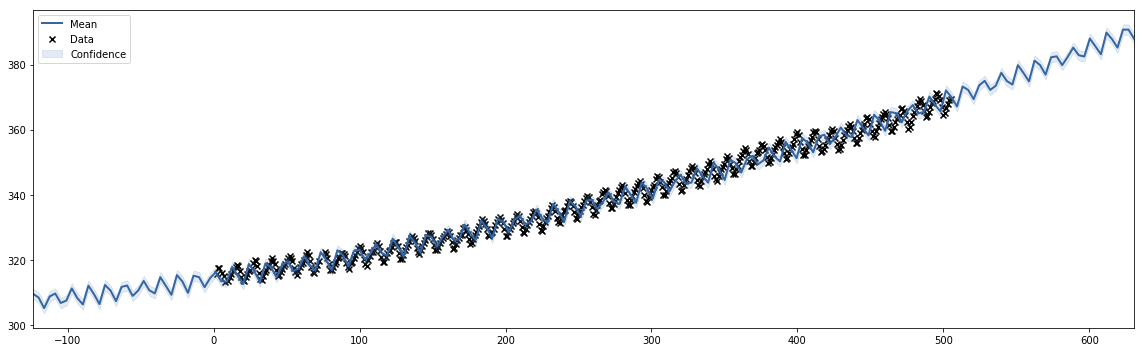

In [194]:
### BEGIN Solution
import GPy


k_trend = GPy.kern.Poly(1, order=2) #+ GPy.kern.RBF(1)
k_periodicity = GPy.kern.StdPeriodic(1) #* GPy.kern.RBF(1)
k_noise = GPy.kern.White(1) #* GPy.kern.Linear(1)
kernel = k_trend+k_periodicity#+k_noise

model = GPy.models.GPRegression(ts[train_index].reshape(-1, 1), X[train_index].reshape(-1, 1), kernel)
#model.sum.std_periodic.variance.fix(1e-3)
#model.sum.std_periodic.period.fix(12)
model.Gaussian_noise.variance.fix(0.601)
model.optimize()

print(model)
model.plot(figsize=(16, 5))


After some tuning of parameteres I chose to fix noise variance. As result we get normal residuals.

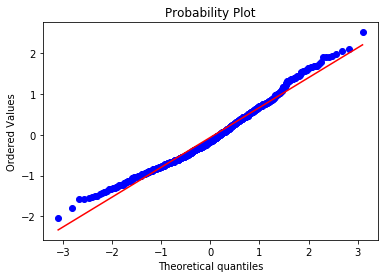

In [197]:
#QQ 
import pylab 
import scipy.stats as stats

resids = X-model._raw_predict(ts.reshape(-1,1))[0][:,0]
stats.probplot(resids, dist="norm", plot=pylab)
pylab.show()

In [198]:
#and here is R^2 estimated on test_data

print(1-np.sum(np.power(resids[test_index],2))/np.sum(np.power(X[test_index]-np.mean(X[test_index]),2)))

## END SOLUTION

0.9953913496


<br/> <!--Intentionally left blank-->